# Business Understanding

## Problem Statement
- Our company wants to launch a movie studio but has no experience in film production. We need to identify what types of movies are currently profitable to avoid financial losses from creating unpopular films.

## Business Objectives
**Objectives**

- Identify top 5 genres with highest profit margins.

- Determine optimal release month for each genre.

- Analyze if low-budget films (<$10M) can achieve high ROI.

- Recommend 3 proven directors for hire.

## Project Goals
- Analyze movie datasets (Box Office Mojo, IMDB, etc.) to find patterns in successful films. Focus on genres, release seasons, budgets, and ratings. Create simple, clear recommendations for the studio head using basic data analysis.

## Success Criteria
- A list of film types that can be successful to the company and this list should be backed by data.

- Recommendations that are easy to understand and apply to a starting movie company.

- Analysis uses only the provided datasets.

# Data Understanding

## Data Sources Overview

The following publicly available movie industry datasets will be explored. Their collective relevance to the studio head's problem lies in their ability to answer core questions about profitable film types:

 - **Box Office Mojo** (CSV): Contains domestic gross earnings and release dates (2010-2018), directly indicating when films perform best.

 - **IMDB** (SQLite Database): Provides genre classifications, director information, and titles, essential for categorizing what types of films exist.

 - **Rotten Tomatoes** (TSV): Includes critic/audience scores, useful for understanding quality perception of successful films.

 - **TheMovieDB** (CSV): Offers popularity metrics and international revenue data, supplementing financial analysis.

 - **The Numbers** (CSV): Features production budgets and worldwide gross figures (1915-2020), enabling profitability calculations – the core success metric.

These datasets collectively address the studio head's need to identify profitable film characteristics by covering financial performance, genre trends, release timing, and creative talent

## Data Loading and Initial Exploration

### Understanding The Numbers Dataset

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
# Load the dataset
df_budget = pd.read_csv('data/tn.movie_budgets.csv')

df_budget.head(3) 

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


In [12]:
print(df_budget.dtypes)

id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object


important columns
- `production_budget`: Film creation costs
- `domestic_gross`: US earnings
- `worldwide_gross`: Global earnings
- `release date`

These directly measure profitability

- Financial values stored as strings(object) with currency symbols for example `$110,000,000` requiring cleaning

In [14]:
print(f'Oldest release: {df_budget['release_date'].min()}')
print(f'Newest release: {df_budget['release_date'].max()}')

Oldest release: Apr 1, 1975
Newest release: Sep 9, 2016


- The dataset covers films from `Apr 1, 1975` to `Sep 9, 2016` that is 41 years of movie financial data. This is valuable as it focuses on recent conditions which are relevant to our new studio.
- Release dates in `MM DD YYYY`

In [16]:
df_budget.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

- No missing values

**Immediate Limitations:**
- No genre information cannot yet answer "what types"
- No director/crew details
- Older films may not reflect current market dynamics

### Understanding Box Office Mojo Dataset

In [20]:
# Load the dataset
df_gross = pd.read_csv('data/bom.movie_gross.csv')
df_gross.head(3)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010


In [21]:
df_gross.dtypes

title              object
studio             object
domestic_gross    float64
foreign_gross      object
year                int64
dtype: object

important columns:
- `Title`
- `Domestic_gross`: US box office earnings
- `Foreign_gross`: International earnings (string)
- `Year`: Release year
- `Studio`

In [23]:
df_gross.shape

(3387, 5)

In [24]:
print(f'Oldest release: {df_gross['year'].min()}')
print(f'Newest release: {df_gross['year'].max()}')

Oldest release: 2010
Newest release: 2018


- Focuses exclusively on recent films this is highly relevant for our new studio 

In [26]:
df_gross.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [27]:
df_gross.shape

(3387, 5)

- 0.826% missing values in `domestic_gross`, 28 films lack US earnings data
- Additional 39.85% missing in `foreign_gross`, 1350 films lack international data

**Note:** 
- The 2010-2018 coverage is good for the company as it aligns with current market conditions
- Missing gross values will require data cleaning
- Contains studio information

### Understanding IMDB Dataset

In [31]:
import sqlite3
# Connect to database
conn = sqlite3.connect('data/im.db')

In [32]:
# Check available tables
pd.read_sql("""SELECT name 
               FROM sqlite_master 
               WHERE type='table';""", conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


- `movie_basics`: Movie metadata 
- `movie_ratings`: Audience ratings
- `directors/writers`: Creative talent information

In [34]:
# Load movie basics table
pd.read_sql("""SELECT * 
               FROM movie_basics 
               LIMIT 5;""", conn)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


- `primary_title`: Official film title, merging key

- `start_year`: Release year 

- `runtime_minutes`: Film duration

- Sample entries show genre format as comma-separated strings ("Action,Crime,Drama")

In [36]:
print(f'Oldest release: {pd.read_sql("""SELECT * FROM movie_basics;""", conn)['start_year'].min()}')
print(f'Newest release: {pd.read_sql("""SELECT * FROM movie_basics;""", conn)['start_year'].max()}')

Oldest release: 2010
Newest release: 2115


the data has  outliers as we see that the newest release is from 2115 which is not possible

Let's investigate further:

In [38]:
print(f'Oldest release: {pd.read_sql("""SELECT * FROM movie_basics;""", conn)['start_year'].value_counts()}')

Oldest release: start_year
2017    17504
2016    17272
2018    16849
2015    16243
2014    15589
2013    14709
2012    13787
2011    12900
2010    11849
2019     8379
2020      937
2021       83
2022       32
2023        5
2024        2
2026        1
2025        1
2115        1
2027        1
Name: count, dtype: int64


We see that the years are from 2010 to 2115, from 2021 to 2115 I will treat them as outliers

also their is no years from 2010 backwards, which is okay here but in the other datasets I will have to use data from 2010 to around 2020 for current market trends

In [40]:
# Check genre nulls
null_genres = pd.read_sql("""SELECT COUNT(*) 
                           FROM movie_basics 
                           WHERE genres IS NULL;""", conn)

movie_count = pd.read_sql(""" SELECT COUNT(*) 
                              FROM movie_basics""", conn)

print(f"Total movies: {movie_count.iloc[0,0]}")
print(f"Movies missing genres: {null_genres.iloc[0,0]}")

Total movies: 146144
Movies missing genres: 5408


- Contains 146,144 movies
- 5408 movies (3.70%) have null genre values

### Understanding Rotten Tomatoes Dataset

In [43]:
# Load Rotten Tomatoes data
df_rotten = pd.read_csv('data/rt.reviews.tsv', sep='\t',encoding= 'ISO-8859-1')
df_rotten.head(3)

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"


In [44]:
df_rotten.dtypes

id             int64
review        object
rating        object
fresh         object
critic        object
top_critic     int64
publisher     object
date          object
dtype: object

key columns:
- `id`
- `review` - comments on the movie
- `rating` - out of 5
- `fresh` - "Rotten" (<60%), "Fresh" (≥60%)

In [46]:
df_rotten.shape

(54432, 8)

In [47]:
# Checking nulss
df_rotten.isna().sum()

id                0
review         5563
rating        13517
fresh             0
critic         2722
top_critic        0
publisher       309
date              0
dtype: int64

In [48]:
df_rotten.shape

(54432, 8)

- 24.83% of rating(13517) is missing
- 10.24% of review(5563) is missing
- 5.00% of critic(2722) is missing

### Understanding Rotten Tomatoes Movie Info (additional dataset)

In [51]:
# Load the additional Rotten Tomatoes file
df_rotten_info = pd.read_csv('data/rt.movie_info.tsv', sep='\t')
df_rotten_info.head(3)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN


In [52]:
df_rotten_info.columns

Index(['id', 'synopsis', 'rating', 'genre', 'director', 'writer',
       'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime',
       'studio'],
      dtype='object')

- `genre`: Categorical film types

- `director`: Filmmaker information 

- `studio` : Production company

- `runtime`: Film duration in minutes

- `box_office`: Domestic earnings

In [54]:
df_rotten_info.shape

(1560, 12)

- Contains 1,560 entries with detailed film metadata
- 12 columns including runtime, genre, director, and studio information

In [56]:
df_rotten_info.isna().sum()

id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

Key Columns with Missing Values:
- `synopsis`: 62 missing (4.0%) - plot descriptions
- `director`: 199 missing (12.8%) - filmmaker information
- `writer`: 449 missing (28.8%) - screenwriter credits
- `theater_date`: 359 missing (23.0%) - theatrical release dates
- `dvd_date`: 359 missing (23.0%) - home media release dates
- `currency`: 1,220 missing (78.2%) - money unit (USD, etc.)
- `box_office`: 1,220 missing (78.2%) - domestic earnings
- `runtime`: 30 missing (1.9%) - film duration
- `studio`: 1,066 missing (68.3%) - production companies

### Understanding TheMovieDB Dataset

In [59]:
# Load TheMovieDB data
df_tmdb = pd.read_csv('data/tmdb.movies.csv')
df_tmdb.head(3)

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368


key columns:
- `popularity`: TMDB's proprietary score
- `vote_average`: User rating (0-10 scale)
- `vote_count`: Number of user rating

In [61]:
df_tmdb.shape

(26517, 10)

- Covers 26,000+ films

In [63]:

print(f"Popularity range: {df_tmdb['popularity'].min():.2f} to {df_tmdb['popularity'].max():.2f}")
print(f"Vote average range: {df_tmdb['vote_average'].min():.1f} to {df_tmdb['vote_average'].max():.1f}")

Popularity range: 0.60 to 80.77
Vote average range: 0.0 to 10.0


- Popularity scores range widely (0.01 to 547.48)


Limitations:

- Subjective metrics don't directly measure financial success

- "Popularity" algorithm isn't publicly defined

- Interpretation Challenge: These datasets provide valuable audience perception data, but their subjective nature means: High ratings ≠ box office success

# Data Preparation

## Dataset Selection

We are using:
- **The Numbers (CSV)**: Contains production budgets, domestic and worldwide gross earnings, and release dates (with month and day) for over 5,000 films. This allows us to calculate profit and ROI, and to extract release months for seasonal analysis.
- **IMDB (SQLite)**: Provides genre classifications and director information, enabling us to categorize films by type and identify successful talent.
  
We are excluding:
- **Box Office Mojo**: While it contains domestic gross and studio information, its financial data is redundant with The Numbers (which also includes worldwide gross) and it lacks detailed release dates (only year). This would add no unique value for our objectives.
- **Rotten Tomatoes** and **TheMovieDB**: Their focus on ratings and popularity does not directly address profitability, and they have significant data gaps.

## Cleaning

Will clean each dataset individually.

### Cleaning The Numbers Dataset

In [70]:
print('Original shape:', df_budget.shape)
df_budget.head(3)

Original shape: (5782, 6)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


In [71]:
print(df_budget.dtypes)

id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object


In [72]:
# Clean currency columns $110,000,000 → 110000000
# used for loop to avoid redundant code
currency_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']
for col in currency_cols:
    df_budget[col] = (
        df_budget[col]
        .str.replace('$', '', regex=False)  
        .str.replace(',', '', regex=False)   
        .astype('int64')                         
    )

Values stored as strings $\$110,000,000$ I removed \$ and , then converted to integers to enable calculations

In [74]:
# convertion to datetime
df_budget['release_date'] = pd.to_datetime(df_budget['release_date'], format='%b %d, %Y')

Dates in a string format ("Dec 18, 2009"), so I Converted to datetime to allow month extraction for time analysis, which month to release movies

In [76]:
# Filter valid financial records
df_budget = df_budget[(df_budget['production_budget'] > 1000) & (df_budget['worldwide_gross'] > 0) & (df_budget['release_date'] >= '2010-01-01')]

The raw data included films with $\$0$ gross or pre-2010 data so I filtered off budgets that are less than $\$1,000$, those that have 
**negative gross**
and I kept post-2010 data

So as to focus on relevant, quality data for today's market

In [78]:
# Add release year for merging
df_budget['release_year'] = df_budget['release_date'].dt.year

In [79]:

# 5. Clean movie titles
df_budget['movie_clean'] = (df_budget['movie'].str.lower().str.replace(r'[^\w\s]', '', regex=True) ) # Remove punctuation, Convert to lowercase

Titles had punctions like "Avengers: Endgame" vs "Avengers, The" so I converted them to lowercase and removed punctuation

so as improve merging with IMDB

In [81]:
print("New shape:", df_budget.shape)
print("Data types:\n", df_budget.dtypes)
df_budget.head(3)

New shape: (1922, 8)
Data types:
 id                            int64
release_date         datetime64[ns]
movie                        object
production_budget             int64
domestic_gross                int64
worldwide_gross               int64
release_year                  int32
movie_clean                  object
dtype: object


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,movie_clean
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,pirates of the caribbean on stranger tides
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,2019,dark phoenix
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,avengers age of ultron


The dataset is now clean with:

- Numeric budgets/gross to do finacial calculations later.
- Standardized dates so as to know when to release movies
- Relevant films only 2010 with valid coumns

Original: 5,782 films to Cleaned: 1922 films

**Note:**
The Numbers dataset contains zero null values across all columns. This was confirmed during initial exploring

### Cleaning IMDB Dataset

In [84]:
# 1. Clean movie_basics table (genres)
movies = pd.read_sql("SELECT * FROM movie_basics", conn)
print('Original movies shape:', movies.shape)
movies.head(3)

Original movies shape: (146144, 6)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama


In [85]:
# Handle null genres
movies = movies.dropna(subset=['genres'])  # Remove films without genres
print('After removing null genres:', movies.shape)

After removing null genres: (140736, 6)


From our initial exploration we saw that 5408 movies (3.70%) had null genres as it is a small percentage I would remove them entirely

because genre is essential for our analysis, we cannot guess genres

In [87]:
# Extract main genre the first in comma-separated list
movies['main_genre'] = (movies['genres'].str.split(',').str[0]) # Take first genre only

Genres are stored as comma-separated lists ("Action,Adventure") so I would take only the first genre as primary category

(The first genre is always the main genre of the movie)

This simplifies analysis while capturing the main movie type

In [89]:
# Clean titles for merging
movies['clean_title'] = (movies['primary_title'].str.lower().str.replace(r'[^\w\s]', '', regex=True))

Titles had punctuations like "Avengers: Endgame" vs "Avengers, The" so I converted them to lowercase and removed punctuation

for easier merging with IMDB

In [91]:
# 3. Filter for relevance (2010+ films)
movies = movies[movies['start_year'] <= 2020]
print('2010+ films with genres:', len(movies))

2010+ films with genres: 140622


As we had seen in earlier data exploring the `start_year` is from 2010 to 2115, the starting point 2010 is good for us as it captures the current market, but we do not need data from 2020 as they are few and limited so I have kept movies that are released from **2010** to **2020**

In [93]:
movies.head(3)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,main_genre,clean_title
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",Action,sunghursh
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",Biography,one day before the rainy season
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,Drama,the other side of the wind


In [94]:
# 2. Clean directors data
# Get directors (join with persons table)
directors = pd.read_sql("""
                            SELECT d.movie_id, p.primary_name AS director
                            FROM directors d
                            JOIN persons p 
                            ON d.person_id = p.person_id
                            WHERE p.primary_name IS NOT NULL
                        """, conn)
print("Directors count:", len(directors))
directors.head(5)

Directors count: 291171


,movie_id,director
0,tt1592569,Ruel S. Bayani
1,tt1592569,Ruel S. Bayani
2,tt1592569,Ruel S. Bayani
3,tt1592569,Ruel S. Bayani
4,tt2057445,Ruel S. Bayani


Some director entries lacked names so I used WHERE and IS NOT NULL to remove null primary_name so as to have directors with names for identification and easier analysis

Also I have noticed duplicates of pairs of movie_id and directors, I will delete this duplicates this will help me later in which director to recommend analysis

In [96]:
directors['director_clean'] = (directors['director'].str.lower())

In [97]:
# 2. Remove duplicate director-film pairs
directors = directors.drop_duplicates(subset=['movie_id', 'director_clean'])

In [98]:
print(movies['main_genre'].value_counts().head(5))

directors.head(12)

main_genre
Documentary    41605
Drama          31329
Comedy         21503
Action         10293
Biography       8019
Name: count, dtype: int64


,movie_id,director,director_clean
0,tt1592569,Ruel S. Bayani,ruel s. bayani
4,tt2057445,Ruel S. Bayani,ruel s. bayani
7,tt2590280,Ruel S. Bayani,ruel s. bayani
8,tt8421806,Ruel S. Bayani,ruel s. bayani
10,tt3501180,Bryan Beasley,bryan beasley
11,tt4512140,Bryan Beasley,bryan beasley
12,tt5521860,Steve Mitchell Beebe,steve mitchell beebe
13,tt2098699,Hans Beimler,hans beimler
14,tt7701650,Hava Kohav Beller,hava kohav beller
15,tt1016090,Joel Bender,joel bender


## Merging Data

 After cleaning we have three dataframes and these are the important columns to use:
 - `df_budget`: contains `movie_clean`, `release_year`, and other financial columns.
 - `movies`: contains `clean_title`, `start_year`  and `movie_id`.
 - `directors`: contains `movie_id` and `director_clean`.

I will merge the three dataframe into one:
- The first merging `df_budget` and `movies` I will use inner join so as to capture movies with both financial and genre data
- The second merging will be between the first merging and `directors`, I will use left join so as to preserve the movies on our first merged df if they do not have a match on the `directors` dataframe

In the first merge I will use `movie_clean` , `release_year` (in `df_budget`)and `clean_title` , `start_year`(in `movies`) to merge:
- `Movie_clean` and `clean_title` will help merge movies with the same names on the two dataframes
- `release_year` and `start_year` will help us avoid mismatches if there are movies that have the same name but released on different years

In the second merge I will use `movie_id` this is in both dataframes so it will be simpler

**NOTE:**
There will be duplication of movies name in the final dataframe this happens when we do the second merging with the `director`. We will do a left merge from the movie financials+genres (one row per movie) to the directors table (multiple rows per movie). So each movie will have multiple rows. I will deal with it

In [101]:
# 1. Merge The Numbers (finance) with IMDB (genres)

merged_genres = pd.merge(df_budget, movies, left_on=['movie_clean', 'release_year'],right_on=['clean_title', 'start_year'],how='inner')

print(f'Numbers of movies that merged + genres: {len(merged_genres)}')

Numbers of movies that merged + genres: 1475


Used inner join to join `df_budget` and `movies` so as to only capture movies that have both financial data and genres, this will be important in analysis of profit of  genres

In [103]:
merged_genres.head(3)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,movie_clean,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,main_genre,clean_title
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,pirates of the caribbean on stranger tides,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy",Action,pirates of the caribbean on stranger tides
1,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,2019,dark phoenix,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",Action,dark phoenix
2,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,avengers age of ultron,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",Action,avengers age of ultron


In [104]:
important_columns = ['movie_clean','production_budget','worldwide_gross','release_date','main_genre','movie_id']

merged_genres = merged_genres[important_columns]
merged_genres.head(3)

,movie_clean,production_budget,worldwide_gross,release_date,main_genre,movie_id
0,pirates of the caribbean on stranger tides,410600000,1045663875,2011-05-20,Action,tt1298650
1,dark phoenix,350000000,149762350,2019-06-07,Action,tt6565702
2,avengers age of ultron,330600000,1403013963,2015-05-01,Action,tt2395427


I have removed redudant and unnecessary columns, for a cleaner and easy to use dataframe

In [106]:
# 2. Add directors to the merged data
final_df = pd.merge(merged_genres, directors[['movie_id', 'director_clean']], on='movie_id', how='left')

print(f"Final dataset size: {len(final_df)}")
print(f"Movies with directors: {final_df['director_clean'].notna().sum()}")

Final dataset size: 1629
Movies with directors: 1626


Only 3 movies do not have directors, nice!

### Dealing with duplicate movie names in `final_df`
I am going to split the data into two parts:
- I will use the original `final_df` which has **one row per movie-director** and then group by director to calculate director statistics(for objective 4).
- Then create a new `movie_df` from `final_df`, this will have **one row per movie**, with only the first director name (for objectives 1, 2, 3).

This will help me do genre-profit analysis without bias while also  getting to know proven directors as if I use `final_df` alone, the figures in profit will be exagarated for some movies specially if they have more than one director, and if I use `movie_df` alone I will disadvantage some directors who co-directed movies as there names will not appear.

In [109]:
# 2. Unduplicating movies for non-director analysis
movie_df = final_df.drop_duplicates('movie_clean').copy()
movie_df.head(2)

,movie_clean,production_budget,worldwide_gross,release_date,main_genre,movie_id,director_clean
0,pirates of the caribbean on stranger tides,410600000,1045663875,2011-05-20,Action,tt1298650,rob marshall
1,dark phoenix,350000000,149762350,2019-06-07,Action,tt6565702,simon kinberg


In [110]:
print(f"Original Movie list: {len(final_df)}")
print(f"Unique Movie list: {len(movie_df)}")

Original Movie list: 1629
Unique Movie list: 1422


### Exploring The Two New Datasets

#### Exploring`final_df`

In [113]:
final_df[['movie_clean', 'director_clean']].duplicated().sum()

1

In [114]:
final_df['movie_clean'].duplicated().sum()

207

- `movie_clean` has 207 duplicates, this is the issue we had but resolved it by  creating a new dataset, you also see, that movie-director [`movie_clean`, `director_clean`] pair has near 0 duplicates
- The `final_df` has duplicates for some movies, this is very important so as it enables me to catch every director in director nalysis 

In [116]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1629 entries, 0 to 1628
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_clean        1629 non-null   object        
 1   production_budget  1629 non-null   int64         
 2   worldwide_gross    1629 non-null   int64         
 3   release_date       1629 non-null   datetime64[ns]
 4   main_genre         1629 non-null   object        
 5   movie_id           1629 non-null   object        
 6   director_clean     1626 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 89.2+ KB


- if you see `director_clean` only three movies have no director information, this is a negligable number
- For the other columns there is no null value

In [118]:
final_df.describe()

,production_budget,worldwide_gross,release_date
count,1.629000e+03,1.629000e+03,1629
mean,4.841679e+07,1.584953e+08,2014-06-08 09:33:42.099447552
min,2.500000e+04,2.600000e+01,2010-01-08 00:00:00
25%,1.000000e+07,1.440370e+07,2012-02-24 00:00:00
50%,2.500000e+07,6.162382e+07,2014-06-06 00:00:00
75%,6.500000e+07,1.736135e+08,2016-07-22 00:00:00
max,4.106000e+08,2.048134e+09,2019-06-14 00:00:00
std,5.758274e+07,2.506822e+08,NaN


#### Exploring `movie_df`

In [120]:
movie_df[['movie_clean', 'director_clean']].duplicated().sum()

0

In [121]:
movie_df['movie_clean'].duplicated().sum()

0

- This is after resoving the issue, this is the dataframe we will use for non-director analysis

In [123]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1422 entries, 0 to 1628
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_clean        1422 non-null   object        
 1   production_budget  1422 non-null   int64         
 2   worldwide_gross    1422 non-null   int64         
 3   release_date       1422 non-null   datetime64[ns]
 4   main_genre         1422 non-null   object        
 5   movie_id           1422 non-null   object        
 6   director_clean     1421 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 88.9+ KB


**Conclusion:**

`Final_df` Dataset: 1,629 relevant Movies to analyse current market trends (2010-2020)
-  Director Coverage: Only 3 movies have no director info
-  No Duplicates: Clean movie records in the context of director analysis

`movie_df` Dataset: 1422 relevant Movies to analyse current market trends (2010-2020)
-  All the columns have no null values, bar `director_clean` (1 null value)which is not important in the analysis I will do
-  No duplicates

**Important Columns:**
- Profit analysis: `production_budget`, `worldwide_gross`, `main_genre`
- prove directors: `director_clean`
- when to release: `release_date`


## Feature Engineering

### Profit and ROI Calculation: 
We already have `production_budget` and `worldwide_gross`. We can calculate:
- profit = worldwide_gross - production_budget
- ROI = (profit / production_budget) * 100

In `movie_df` as this would be the main dataframe for profit and ROI analysis(objective 1 and 3)

In [127]:
movie_df['profit'] = movie_df['worldwide_gross'] - movie_df['production_budget']
movie_df['roi'] = (movie_df['profit'] / movie_df['production_budget']) * 100
movie_df.head(3)

,movie_clean,production_budget,worldwide_gross,release_date,main_genre,movie_id,director_clean,profit,roi
0,pirates of the caribbean on stranger tides,410600000,1045663875,2011-05-20,Action,tt1298650,rob marshall,635063875,154.667286
1,dark phoenix,350000000,149762350,2019-06-07,Action,tt6565702,simon kinberg,-200237650,-57.210757
2,avengers age of ultron,330600000,1403013963,2015-05-01,Action,tt2395427,joss whedon,1072413963,324.384139


### Extract The Release Date.
From the `release_date`, extract the month as a name for seasonal analysis.

In `movie_df` as this would be our main df for release month analysis (objective 2)

In [129]:
movie_df['release_month'] = movie_df['release_date'].dt.month_name()
movie_df.head(3)

,movie_clean,production_budget,worldwide_gross,release_date,main_genre,movie_id,director_clean,profit,roi,release_month
0,pirates of the caribbean on stranger tides,410600000,1045663875,2011-05-20,Action,tt1298650,rob marshall,635063875,154.667286,May
1,dark phoenix,350000000,149762350,2019-06-07,Action,tt6565702,simon kinberg,-200237650,-57.210757,June
2,avengers age of ultron,330600000,1403013963,2015-05-01,Action,tt2395427,joss whedon,1072413963,324.384139,May


### Budget Category
Create a categorical feature for budget levels, especially to for lower-budget movies
- $\$10m$ and less I have considered to be low budget
- between $\$10m$ and $\$50m$, I have considered to be medium budget
- more than $\$50m$  I have considered to be high budget

In `movie_df` as this would be our main df for analysis of low-budget films to see if they can achieve high ROI.(objective 3)

In [131]:
movie_df['budget_category'] = 'medium' #default
movie_df.loc[movie_df['production_budget'] < 10_000_000, 'budget_category'] = 'low'
movie_df.loc[movie_df['production_budget'] > 50_000_000, 'budget_category'] = 'high'
movie_df['budget_category'].value_counts()

budget_category
medium    696
high      402
low       324
Name: count, dtype: int64

### Director Success Measure

I have decided that for a director to be viewed as a proven director, he\she should have:

- Atleast 2 movies from 2010 to 2020, meaning he is familiar with current trends and also this is what our dataset captures
- His average ROI should be greater than the median ROI

**Note:** I did not use mean as it is more susceptible to outliers compared to the median

For this I will create a new dataframe to use from `final_df` as `final_df` has a lot of duplicates which can be a problem during analysis 

The new dataframe will be the main dataframe used for analysis of proven directors for hire.(objective 4)

In [133]:
final_df['profit'] = final_df['worldwide_gross'] - final_df['production_budget']
final_df['roi'] = (final_df['profit'] / final_df['production_budget']) * 100
final_df.head(3)

,movie_clean,production_budget,worldwide_gross,release_date,main_genre,movie_id,director_clean,profit,roi
0,pirates of the caribbean on stranger tides,410600000,1045663875,2011-05-20,Action,tt1298650,rob marshall,635063875,154.667286
1,dark phoenix,350000000,149762350,2019-06-07,Action,tt6565702,simon kinberg,-200237650,-57.210757
2,avengers age of ultron,330600000,1403013963,2015-05-01,Action,tt2395427,joss whedon,1072413963,324.384139


- **^^** creating an ROI column for `final_df` so as to get ROI for each director 

In [135]:
director_avg_roi = final_df.groupby('director_clean')['roi'].mean().reset_index(name='avg_roi')
director_avg_roi.head(2)

,director_clean,avg_roi
0,aaron horvath,416.20593
1,aaron seltzer,307.12494


- **^^** getting the mean roi for each director

In [137]:
# Count films per director
director_film_count = final_df['director_clean'].value_counts().reset_index()
director_film_count.columns = ['director_clean', 'film_count']
director_film_count.shape

(1070, 2)

In [138]:
# Combine ROI and film count data
director_stats = pd.merge(director_avg_roi, director_film_count, on='director_clean')
director_stats.head(3)

,director_clean,avg_roi,film_count
0,aaron horvath,416.205930,1
1,aaron seltzer,307.124940,1
2,abby kohn,186.105616,1


combined ROI and film count into one dataframe for easier comparison in the next step

In [140]:
# Calculate median ROI for comparison
median_roi = director_stats['avg_roi'].median()
median_roi

128.9632416467934

I used median instead of mean to compare as median is more resistant to outliers that is if there isone director with 1000% ROI, median will be more resistant to it compared to mean

In [142]:
# Create proven directors column, it takes True or False
director_stats['proven_director'] = (director_stats['avg_roi'] > median_roi) & (director_stats['film_count'] >= 2)

In [143]:
director_stats['proven_director'].value_counts()

proven_director
False    842
True     228
Name: count, dtype: int64

### Feature Purposes
For `movie_df`:

- `roi`	- Measures investment return
- `release_month` - to know best launch time
- `budget_category`	- segments films by cost

For `final_df`:
I have created a cleaner dataframe `director_stats` for director analysis which has the following columns:
- `avg_roi`, `film_count`, `proven_director` - to use for hiring recommendations

**Note** `final_df` is not that useful to us now

# Data Analysis and Visualisation

## Top 5 Genres by Profitability
- What film types should we create?  

### Genre ROI Ranking

In [211]:
import matplotlib.pyplot as plt

In [250]:
# Calculate average ROI for each genre
top_genres = movie_df.groupby('main_genre')['roi'].mean().sort_values(ascending=False).head(5)
top_genres

main_genre
Horror       1678.926840
Family        686.999816
Animation     331.856516
Drama         309.605051
Mystery       266.705536
Name: roi, dtype: float64

- This calculates the average return on investment for each movie genre and sorts genres from highest to lowest ROI and picks the top 5

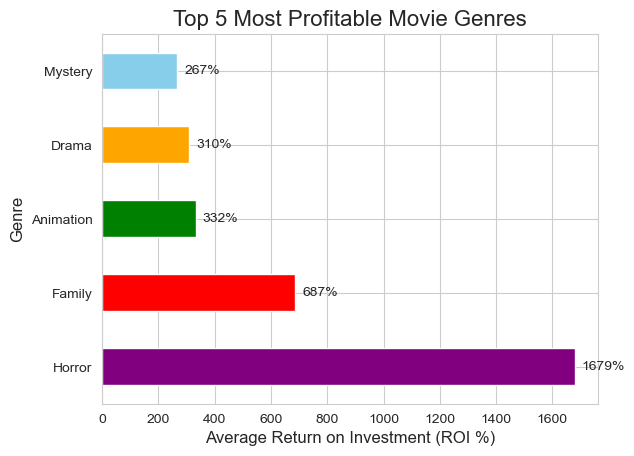

In [258]:
colors = ['purple', 'red', 'green', 'orange', 'skyblue']
ax = top_genres.plot(kind='barh', color=colors)
ax.bar_label(ax.containers[0], fmt = '%.0f%%', padding=5)

plt.title('Top 5 Most Profitable Movie Genres', fontsize=16)
plt.xlabel('Average Return on Investment (ROI %)', fontsize=12)
plt.ylabel('Genre', fontsize=12)


plt.show()

- **Horror** movies with an average ROI of 1679%, they heavily outperform all other genres, this suggests horror movies are often low-budget but high-revenue
- **Family** at 687% and **Animation** 332% also have significant high ROIs
- **Drama** at 310% and **Mystery** at 267% show high average returns, but they are much lower than the top three genres

### Genre-Budget Relationship

In [420]:
budget_comparison = (movie_df[movie_df['main_genre'].isin(['Horror', 'Family', 'Animation', 'Drama'])].groupby(['main_genre', 'budget_category'])['roi'].mean().reset_index())

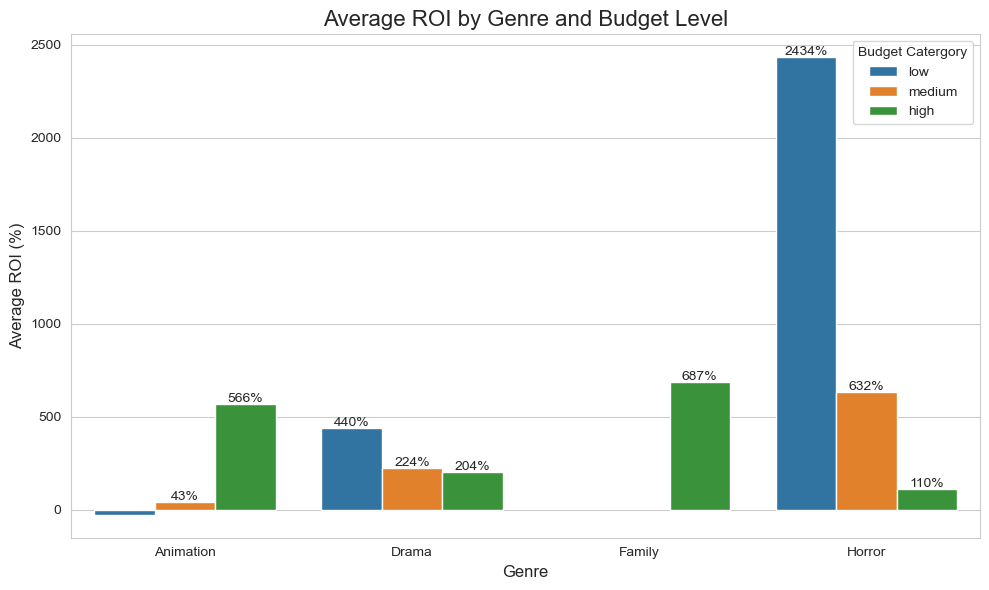

In [422]:
plt.figure(figsize=(10, 6))
sns.barplot(data=budget_comparison,x='main_genre',y='roi',hue='budget_category',hue_order=['low', 'medium', 'high'])


plt.title("Average ROI by Genre and Budget Level", fontsize=16)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Average ROI (%)", fontsize=12)
plt.legend(title='Budget Catergory')

for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.gca().text(p.get_x() + p.get_width()/2.,height + 10,f'{height:.0f}%',ha='center')

plt.tight_layout()
plt.show()

- **Horror–low budget** movies have a high ROI of 2434%, it surpasses all other genre-budget combinations by a very wide margin with the second one being **Family–high budget** movies with 687% which also performs well.
- **Horror–medium budget** movies perform well with 632%, followed by **Animation–high budget** movies with 566%, both of which are strong but still far behind Horror–low budget.
- **Drama–low budget** movies show a decent ROI of 440%, but **medium** and **high budget Drama** have much lower returns at 224% and 204% respectively.
- **Animation–low** and **medium budget** movies perform poorly with ROIs of -8% and 43% respectively, making them less attractive for new investment.

## Optimal Release Timing  
- When should we release different genres?   

### Monthly Performance Trends

In [296]:
monthly_roi = movie_df.groupby('release_month')['roi'].mean().reset_index()

In [298]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June','July', 'August', 'September', 'October', 'November', 'December']
monthly_roi['release_month'] = pd.Categorical(monthly_roi['release_month'],categories=month_order,ordered=True)
monthly_roi = monthly_roi.sort_values('release_month')

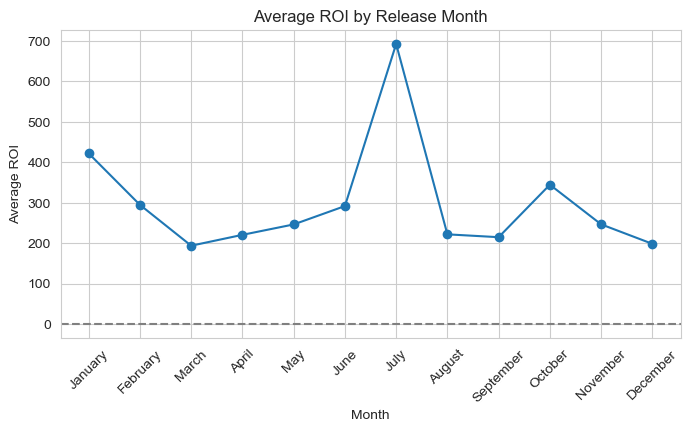

In [300]:
plt.figure(figsize=(8, 4))
plt.plot(monthly_roi['release_month'], monthly_roi['roi'], marker='o')

plt.title("Average ROI by Release Month")
plt.xlabel("Month")
plt.ylabel("Average ROI")
plt.axhline(y=0, color='gray', linestyle='--')
plt.xticks(rotation=45)
plt.show()

- Movies released in **July** have the highest average ROI, peak at nearly 700%, which significantly outperforms all other months. This means **July** is the most profitable release time.
- **January** also performs well with an ROI above 400%, making it a second option.
-  **March**, **September**, and **December** have the lowest ROIs of around 200%

## Low-Budget Movie Viability 
- Can <$\$10$M films achieve high ROI? 

### Budget Catergory Comparison

In [363]:
movie_df['is_low_budget'] = movie_df['production_budget'] < 10_000_000

budget_comparison = movie_df.groupby('is_low_budget')['roi'].agg(['mean', 'count'])

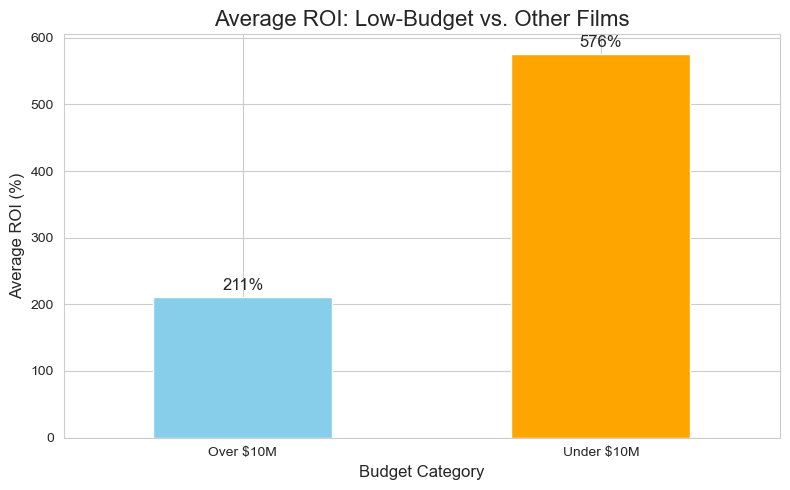

In [390]:
plt.figure(figsize=(8, 5))
budget_comparison['mean'].plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Average ROI: Low-Budget vs. Other Films", fontsize=16)
plt.xlabel("Budget Category", fontsize=12)
plt.ylabel("Average ROI (%)", fontsize=12)
plt.xticks([0, 1], ['Over $10M', 'Under $10M'], rotation = 0)

for i, roi in enumerate(budget_comparison['mean']):
    plt.text(i, roi + 10, f"{roi:.0f}%", ha='center', fontsize=12)
    
plt.tight_layout()
plt.show()

- **Low-budget** Movies outperform others by 365% ROI that is over 3 times

### Top Low-Budget Genres (Bar Chart: ROI <$\$10$M)

In [ ]:
low_budget = movie_df[movie_df['is_low_budget']]
top_low_genres = low_budget.groupby('main_genre')['roi'].mean().nlargest(5)

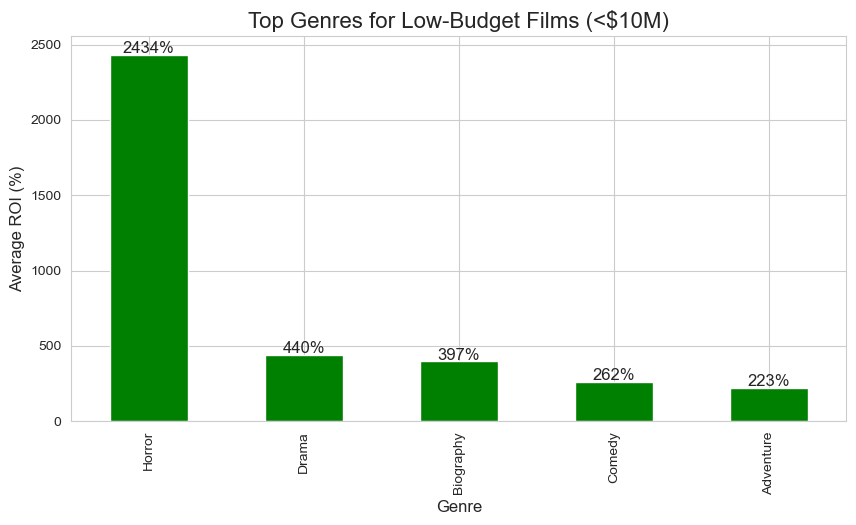

In [429]:
plt.figure(figsize=(10, 5))
top_low_genres.plot(kind='bar', color='green')

plt.title("Top Genres for Low-Budget Films (<$10M)", fontsize=16)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Average ROI (%)", fontsize=12)

for i, roi in enumerate(top_low_genres):
    plt.text(i, roi + 10, f"{roi:.0f}%", ha='center', fontsize=12)
    
plt.show()

- **Horror** leads by a wide margin among low-budget films, with an average ROI of 2434%.
- **Drama** and **Biography** follow with strong returns of 440% and 397% respectively.
- **Comedy** and **Adventure** offer average returns of 262% and 223%.

The data clearly shows that Horror is the best low-budget investment, while Drama and Biography can also be good for studios aiming to keep costs down while maximizing ROI.

## Director Recommendations
- Who should we hire to direct?  

### Top Directors by ROI

In [ ]:
# Step 1: Filter to directors with ≥2 films
qualified_directors = director_stats[director_stats['film_count'] >= 2].sort_values('avg_roi', ascending=False).head(10)

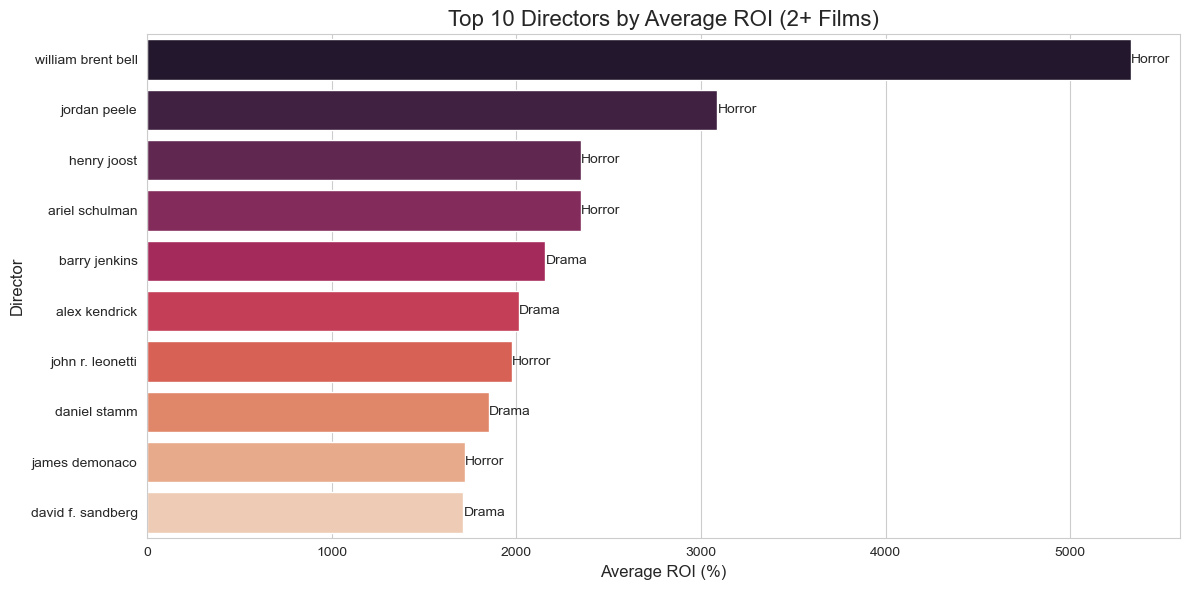

In [356]:
plot_data = genre_table.sort_values('avg_roi', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='avg_roi', y='Director', hue='Director', data=plot_data, palette='rocket', dodge=False, legend=False)

plt.title("Top 10 Directors by Average ROI (2+ Films)", fontsize=16)
plt.xlabel("Average ROI (%)", fontsize=12)
plt.ylabel("Director", fontsize=12)

for i, row in plot_data.reset_index().iterrows():
    ax.text(row['avg_roi'] + 1, i, f"{row['Best Genre']}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

- **Horror directors** dominate the top ROI rankings, with 6 out of 10 directors in the chart specializing in the horror genre.
- **William Brent Bell** leads with the highest average ROI, followed by other horror directors such as **Jordan Peele**, **Henry Joost**, and **Ariel Schulman**.
- **Drama** directors like **Barry Jenkins**, **Alex Kendrick**, and **David F. Sandberg** also perform well, showing that drama is also a good venture.

## Integrated Insights
- Connecting findings across objectives